# Fake News Detection: GAT

### Installation

In [22]:
import torch
import torch_geometric
from torch_geometric.datasets import UPFD
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch_geometric.utils import to_networkx

### Dataset

In [2]:

train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting .\gossipcop\raw\uc
Processing...
Done!


Train Samples:  1092
Test Samples:  3826


### EDA

In [9]:
train_data.__dict__

{'root': '.',
 'name': 'gossipcop',
 'feature': 'content',
 'transform': None,
 'pre_transform': None,
 'pre_filter': None,
 'log': True,
 '_indices': None,
 'slices': defaultdict(dict,
             {'x': tensor([    0,    76,   201,  ..., 63397, 63455, 63482]),
              'edge_index': tensor([    0,    75,   199,  ..., 62307, 62364, 62390]),
              'y': tensor([   0,    1,    2,  ..., 1090, 1091, 1092])}),
 '_data': Data(x=[63482, 310], edge_index=[2, 62390], y=[1092]),
 '_data_list': [None,
  Data(x=[125, 310], edge_index=[2, 124], y=[1]),
  Data(x=[6, 310], edge_index=[2, 5], y=[1]),
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  N

In [21]:
sample_id=2
print(f'train_data : {train_data[sample_id]}')
print(f'train_data x: {train_data[sample_id].x}')
print(f'train_data edge_index: {train_data[sample_id].edge_index}')


train_data : Data(x=[6, 310], edge_index=[2, 5], y=[1])
train_data x: tensor([[0.5170, 0.5350, 0.5372,  ..., 0.2603, 0.1250, 0.2500],
        [0.5523, 0.5490, 0.5262,  ..., 0.1164, 0.0556, 0.2647],
        [0.5076, 0.5370, 0.5431,  ..., 0.2055, 0.1667, 0.3088],
        [0.5523, 0.5490, 0.5262,  ..., 0.1164, 0.0556, 0.2647],
        [0.5170, 0.5350, 0.5372,  ..., 0.2603, 0.1250, 0.2500],
        [0.4556, 0.5051, 0.5530,  ..., 0.6027, 0.2222, 0.1618]])
train_data edge_index: tensor([[0, 0, 0, 1, 1],
        [1, 2, 3, 4, 5]])


<Axes: ylabel='count'>

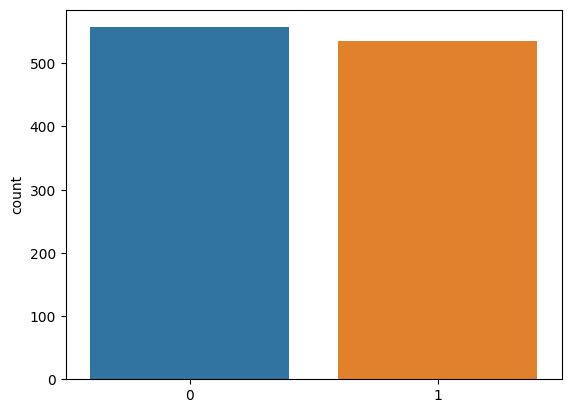

In [20]:
y = train_data.y.numpy()
sns.countplot(x = y)

train_data[sample_id].y: tensor([1])


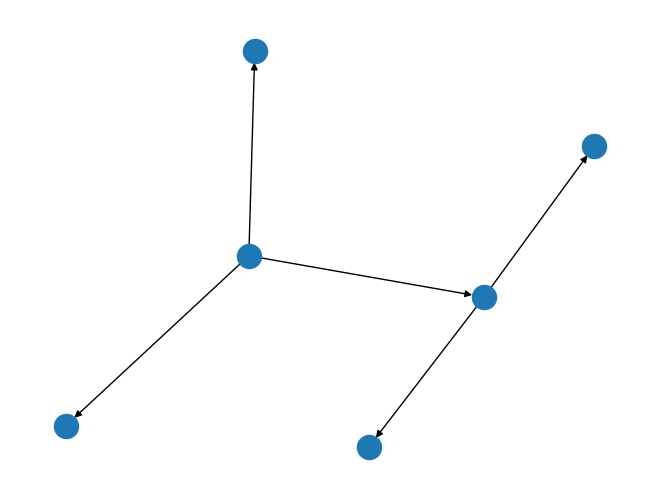

In [30]:
nx.draw(to_networkx(train_data[sample_id]))
print(f'train_data[sample_id].y: {train_data[sample_id].y}')

train_data[1].y: tensor([1])


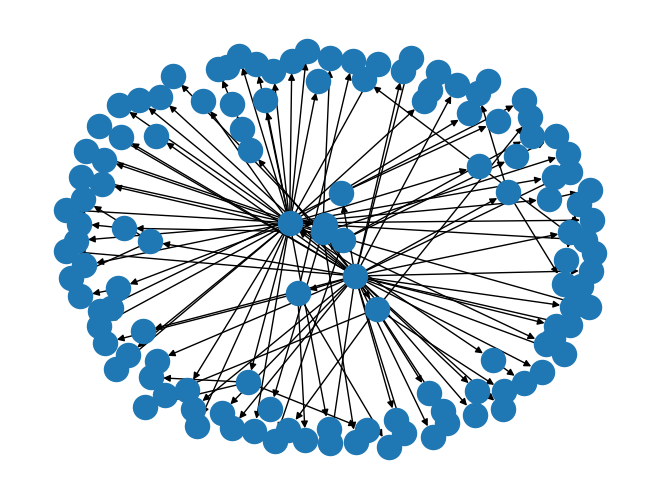

In [31]:
nx.draw(to_networkx(train_data[1]))
print(f'train_data[1].y: {train_data[1].y}')

train_data[0].y: tensor([0])


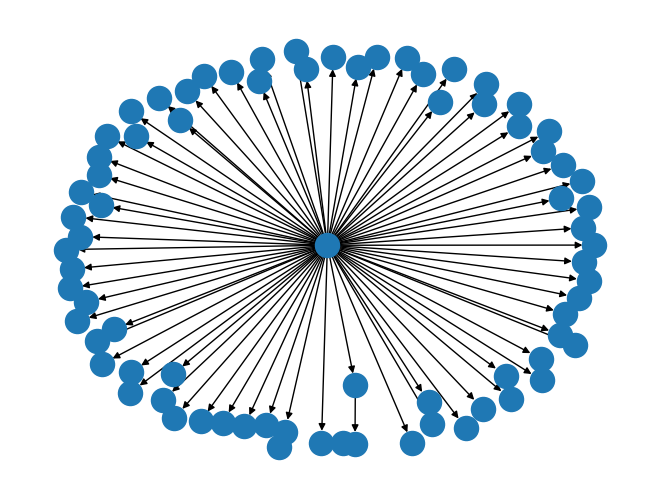

In [33]:
nx.draw(to_networkx(train_data[0]))
print(f'train_data[0].y: {train_data[0].y}')

### Model

In [34]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear

In [35]:
print(f'train_data.num_features {train_data.num_features}')

train_data.num_features 310


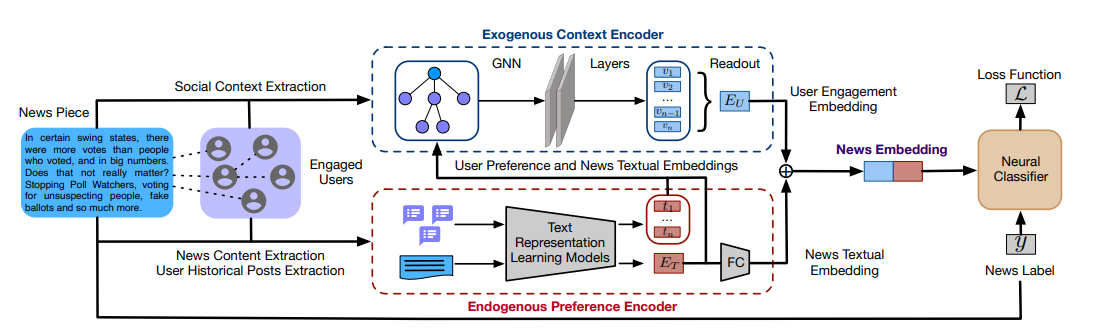

In [78]:
from IPython.display import Image
Image(filename="UPDF_Framework.png")
paper_link = https://arxiv.org/pdf/2104.12259.pdf


In [65]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
    
        #x.shape : torch.Size([nodes, features])
        #edge_index.shape : torch.Size([2, 3916])
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu() 
        #h.shape before Polling: torch.Size([nodes, feature_embedding])
        #Calculates the new Embedding for each node
        
        #For <each Batch combines/pools all the Embeddings and calculates one general embedding 
        #-> used for classification
        h = gmp(h, batch) #Redout in Paper
        # #h.shape after Polling: torch.Size([batch, feature_embedding])
        
        h = self.lin0(h).relu()
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0) #[batch,1]
         
        # news information -> based on  word2vec embeddings 
        news = x[root]                    #[batch,features]   # News Textual Embedding in Paper
        news = self.lin_news(news).relu() #[batch,feature_embedding]
        
        out = self.lin1(torch.cat([h, news], dim=-1)) # [batch_size, output_size(1)]
        
        return torch.sigmoid(out)

GNN(train_data.num_features, 136, 1)

GNN(
  (conv1): GATConv(310, 136, heads=1)
  (conv2): GATConv(136, 136, heads=1)
  (conv3): GATConv(136, 136, heads=1)
  (lin_news): Linear(in_features=310, out_features=136, bias=True)
  (lin0): Linear(in_features=136, out_features=136, bias=True)
  (lin1): Linear(in_features=272, out_features=1, bias=True)
)

### Training

In [66]:
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.loader import DataLoader

In [75]:

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch) #out shape: torch.Size([64, 1])
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1


def metrics(preds, gts):
    preds = torch.round(torch.cat(preds))
    gts = torch.cat(gts)
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts)
    return acc, f1

In [77]:
for epoch in range(40):
    train_loss = train(epoch)
    if (epoch %5 == 0) or(epoch == 39):
        test_loss, test_acc, test_f1 = test(epoch)
        print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
            f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.78 | TestLoss: 0.70 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 05 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.81 | TestF1: 0.84
Epoch: 10 |  TrainLoss: 0.65 | TestLoss: 0.64 | TestAcc: 0.80 | TestF1: 0.76
Epoch: 15 |  TrainLoss: 0.61 | TestLoss: 0.61 | TestAcc: 0.54 | TestF1: 0.68
Epoch: 20 |  TrainLoss: 0.51 | TestLoss: 0.52 | TestAcc: 0.75 | TestF1: 0.80
Epoch: 25 |  TrainLoss: 0.45 | TestLoss: 0.44 | TestAcc: 0.87 | TestF1: 0.88
Epoch: 30 |  TrainLoss: 0.40 | TestLoss: 0.43 | TestAcc: 0.77 | TestF1: 0.71
Epoch: 35 |  TrainLoss: 0.46 | TestLoss: 0.52 | TestAcc: 0.68 | TestF1: 0.76
Epoch: 39 |  TrainLoss: 0.35 | TestLoss: 0.35 | TestAcc: 0.85 | TestF1: 0.83
